In [1]:
# Copyright 2023 Regeneron Pharmaceuticals Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Notebook to compare Physiochemical embeddings to One-Hot encodings for TCRs
    -TCRs are preprocessed the same way with the gap padding then either Physiochemically encoded or 1-hot encoded.
    -They are then PC'ed down to 16D and clusterd using the same DBscan loop varying eps radius parameter with cluster minsize of 3.
    - We find minimal difference by clustering with the raw Physiochemical properties or 1-hot encoded features as illustrated in final figure.

In [9]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tcrvalid.load_models import *
from tcrvalid.physio_embedding import SeqArrayDictConverter
from tcrvalid.data_subsetting import *
from tcrvalid.cluster_loop import *
from tcrvalid.defaults import *
import os 
import sys
from pathlib import Path
from os.path import dirname as up

sys.path.append('../comparitor_tooling/distance_based_tools')
from tcrclustering.cluster.prep_gliph_data import *


In [10]:
mapping = SeqArrayDictConverter()
trb_test_pq = data_path_small_trb['te']
te_seq_trb_df = pd.read_parquet(trb_test_pq, columns=['cdr2_cdr3','new_meta_vcall','j_call','insert_codons_aa']).head(100000)

df_ref_gliph=prep_gliph_data('TRB','ref')
df_ref_tcrvalid = get_data('TRB', False)


df_ref_orig=prep_gliph_data('TRB','ref')
two_up = up(os.getcwd())  
path='/tcrvalid/data/VDJDB_TCRs_w_quality.tsv'
VDJDB_ref=pd.read_csv(two_up+path,sep='\t')
VDJDB_ref['v_gene_TRB'] = VDJDB_ref['V'].str.split('*').str[0]
VDJDB_ref['j_gene_TRB'] = VDJDB_ref['J'].str.split('*').str[0]
VDJDB_ref=VDJDB_ref.rename(columns={'CDR3':'cdr3_TRB','Epitope':'peptide'}) 
tmp_df2=df_ref_orig.merge(VDJDB_ref,on=['v_gene_TRB','cdr3_TRB','j_gene_TRB','peptide'],how='left')
Filtered=tmp_df2.loc[(tmp_df2["Gene"]=='TRB') & (tmp_df2["Score"]>0),]                       
Filtered=Filtered[[ 'sequence_id','cdr3_TRB', 'v_call', 'j_call', 'peptide','Score', 'source', 'v_gene_TRB', 'j_gene_TRB', 'new_v_call', 'cdr1_no_gaps', 'cdr2_no_gaps', 'cdr1_cdr2_no_gaps', 'clono_id', 'v_gene_TRA', 'j_gene_TRA', 'cdr3_TRA']]
Filtered=Filtered.sort_values(by=['clono_id','Score'], ascending=False)
df_ref_HQ=Filtered.drop_duplicates('clono_id')

/data/home/allen.leary/repos/tcrvalid/tcrvalid/data_subsetting.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pre_feature'] = df['cdr2_no_gaps'] + '-' + df.junction_aa.map(lambda x: x[1:-1])


In [11]:
# Import Dependencies 
import pandas as pd
import numpy as np

# Function to encode sequences
def encode_seq(sequence):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','-']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = list()

    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)

    return np.array(onehot_encoded)
def get_xflat(x):
  x_flat = np.reshape(x, (x.shape[0],x.shape[1]*x.shape[2]))
  return x_flat

In [30]:
references=[df_ref_tcrvalid,df_ref_gliph,df_ref_HQ]
Combo_PC=[]
Combo_onehot=[]

for df_ref in references:
    df = df_ref.filter(['clono_id'])
    df['padded']=df['clono_id'].str.pad(width=28, side='right', fillchar='-')
    # Create a new column Encoded_Sequences containing encoded sequences from Sequence column
    df['Encoded_Sequences'] = df['padded'].apply(lambda x: encode_seq(x))
    newarray = np.stack(df.Encoded_Sequences)
    x_PC = mapping.seqs_to_array(list(df.clono_id.values),maxlen=28)
    x_onehot = np.stack(df.Encoded_Sequences)
    x_PC_flat = get_xflat(x_PC)
    x_flat_onehot = get_xflat(x_onehot)
    n=16
    pca_PC = PCA(n_components=n)
    x__PC_pca=pca_PC.fit_transform(x_PC_flat)
    Combo_PC.append(x__PC_pca)
    pca_onehot = PCA(n_components=n)
    x__onehot_pca=pca_onehot.fit_transform(x_flat_onehot)
    Combo_onehot.append(x__onehot_pca)
    


In [31]:
eps_range = np.linspace(2.0,12.0,15)
reference_name=['tcrvalid','gliph','gliph_HQ']
master_score_PC = pd.DataFrame() 
for index,ref in enumerate(references):
    temp_df = dbscan_loop(
    ref,
    Combo_PC[index],
    eps_range,
    metric='manhattan',
    eps_format=':.2f'
    )
    temp_df['reference']=reference_name[index]
    master_score_PC = master_score_PC.append(temp_df) 


/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[eps_name] = dbs.labels_ # put cluster labels back into df that goes with representations
/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[eps_name] = dbs.labels_ # put cluster labels back into df that goes with representations
/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is

In [32]:
eps_range = np.linspace(0.5,3.5,15)
reference_name=['tcrvalid','gliph','gliph_HQ']
master_score_1HOT = pd.DataFrame() 
for index,ref in enumerate(references):
    temp_df = dbscan_loop(
    ref,
    Combo_onehot[index],
    eps_range,
    metric='manhattan',
    eps_format=':.2f'
    )
    temp_df['reference']=reference_name[index]
    master_score_1HOT = master_score_1HOT.append(temp_df) 


/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[eps_name] = dbs.labels_ # put cluster labels back into df that goes with representations
/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[eps_name] = dbs.labels_ # put cluster labels back into df that goes with representations
/data/home/allen.leary/repos/tcrvalid/tcrvalid/cluster_loop.py:57: SettingWithCopyWarning: 
A value is

In [35]:
master_score_1HOT = master_score_1HOT.drop(master_score_1HOT[(master_score_1HOT['epsilon'] == 2.21) & (master_score_1HOT['reference'] =='gliph_HQ')].index)

In [44]:
colorblind = sns.color_palette("muted", 10)
method_colors = {
    'tcrdist' : colorblind[0],
    'tcr-bert': colorblind[0],
    'ESM': colorblind[1],
    'ismart': colorblind[1],
    'TCR_VALID':colorblind[2],
    'GLIPH':colorblind[4],
    '1HOT':colorblind[0],
    'PC':colorblind[1]

    
}
concatenated_seq_encoding = pd.concat([master_score_1HOT.assign(Method = '1HOT'), 
                                                   master_score_PC.assign(Method = 'PC')])
concatenated_seq_encoding=concatenated_seq_encoding.rename(columns={"well_clustered_total": "c-CSI","well_clustered": "c-precision",})

save_name='../comparitor_tooling/1HotvsPC_score.csv'
concatenated_seq_encoding.to_csv(save_name)


../comparitor_tooling/1HotvsPC


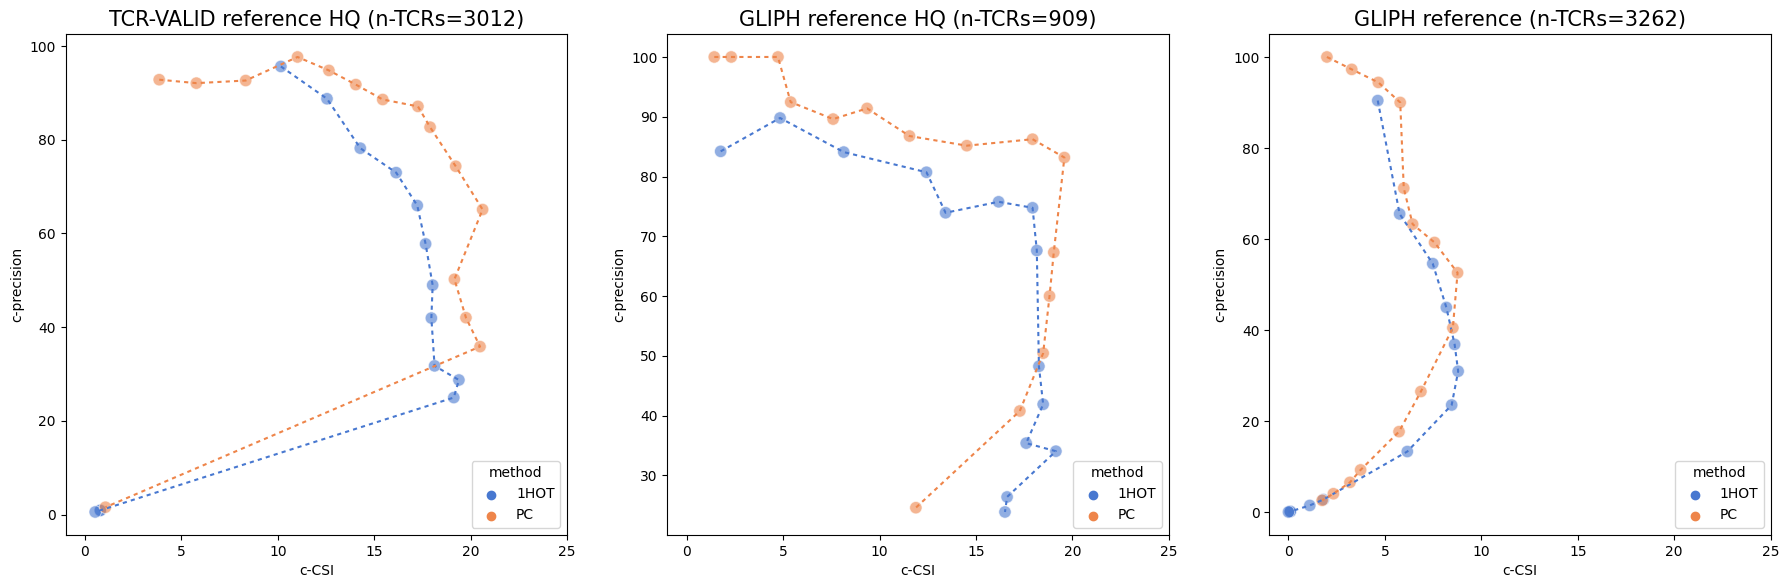

In [43]:
colorblind = sns.color_palette("muted", 10)
method_colors = {
    'tcrdist' : colorblind[0],
    'tcr-bert': colorblind[0],
    'ESM': colorblind[1],
    'ismart': colorblind[1],
    'TCR_VALID':colorblind[2],
    'GLIPH':colorblind[4],
    '1HOT':colorblind[0],
    'PC':colorblind[1]
}
f,axes = plt.subplots(1,3,figsize=(22,6.5))
references=['tcrvalid','gliph_HQ','gliph']
references_names=['TCR-VALID reference HQ (n-TCRs=3012)','GLIPH reference HQ (n-TCRs=909)','GLIPH reference (n-TCRs=3262)']
minsize=2
xlim=[-1,25]
for j, ax in enumerate(axes):
        plotting_df=concatenated_seq_encoding[(concatenated_seq_encoding['reference']==references[j])]
        axes=sns.scatterplot(x='c-CSI', y='c-precision', hue='Method', s=80,alpha=.6, 
                         palette=method_colors,data=plotting_df,ax=ax)
        axes2=sns.lineplot(x = 'c-CSI', y = 'c-precision', data = plotting_df,
                           hue='Method',sort=False,style=True,dashes=[(2, 2)],palette=method_colors,legend=None,ax=ax)
        #axes4.legend().remove()
        #axes4.set(xlabel=None)
        ax.set_title(references_names[j],fontsize=15)
        ax.set_xlim(xlim)
        ax.legend(loc="lower right",title='method')

save_name='../comparitor_tooling/1HotvsPC'
f.savefig(save_name+'.pdf',bbox_inches='tight')  
        